# About Data

**This dataset was formatted by R. Olszewski as part of his thesis
“Generalized feature extraction for structural	pattern recognition
in time-series data,” at Carnegie Mellon University, 2001. Each
series traces the electrical activity recorded during one
heartbeat. The two classes are a normal heartbeat and a Myocardial
Infarction.**

# Import Librarys

In [1]:
! pip install tensorflow_addons 
! pip install dash==2.0.0
! pip install plotly

# Import Librarys

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
import tensorflow_addons as tfa
import urllib.request
import zipfile
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  if sys.path[0] == '':


# Preprocessing

In [3]:
urllib.request.urlretrieve("https://timeseriesclassification.com/Downloads/ECG200.zip",'/content/ecg200.zip')

with zipfile.ZipFile('/content/ecg200.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ecg200/')

train = pd.read_csv('/content/ecg200/ECG200_TRAIN.txt', header=None, sep='\n')
train = train[0].str.split('  ',expand=True).iloc[:,1:]
train = train.applymap(float)

test = pd.read_csv('/content/ecg200/ECG200_TEST.txt', header=None, sep='\n')
test = test[0].str.split(r"\s+",expand=True).iloc[:,1:]
test = test.applymap(float)

train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

# Training dataset 

In [4]:
df = pd.read_csv('./train.csv')
df1 = df.iloc[:,1:]
print('dataframe shape :',df.shape)
df.head(3)

dataframe shape : (100, 97)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,0.380282,-0.296780,-0.513929,-0.255645,-0.107203,-0.287827,-0.418009,-0.319163,-0.260379,-0.350357,-0.505486,-0.710887,-0.823920,-0.899702,-1.153950,-1.229831,-1.044091,-1.202031,-1.392195,-1.130108,-1.179867,-1.649272,-1.726575,-1.608370,-1.662802,-1.650672,-1.697309,-1.838697,-1.802596,-1.780536,...,0.683870,0.474995,0.532797,0.723550,0.664420,0.647936,0.757054,0.732072,0.620215,0.606297,0.677950,0.689084,0.598807,0.542647,0.581807,0.630631,0.664420,0.686318,0.657383,0.650889,0.721738,0.739706,0.691481,0.695229,0.750115,0.853845,0.916019,0.827750,0.880906,1.088831,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,-1.179593,-1.055926,-1.128777,-0.686039,-0.798789,-1.714279,-1.649858,-1.032699,-1.423918,-1.782433,-1.025126,-1.798909,-1.793614,-1.085478,-1.574390,-1.036059,-2.130021,-2.038621,-0.055013,-1.140195,-0.704275,0.048723,-0.475854,0.525865,0.244778,0.679932,0.928601,0.573041,1.231607,1.043324,...,0.631120,0.694075,0.515071,0.559229,0.555712,0.469694,0.388821,0.343129,0.535598,0.900708,0.656846,0.690033,0.952596,0.547770,-0.167693,0.011532,-0.176488,-0.277706,-0.224836,-0.910723,-0.037932,0.071668,-1.048920,-0.636218,-0.386637,-0.507512,-0.716656,-0.463758,-0.460442,-0.770792,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,0.499957,-0.022363,-0.235318,-0.118273,-0.071027,-0.322986,-0.433562,-0.318660,-0.295655,-0.417733,-0.682480,-0.881840,-0.843320,-0.883652,-1.030018,-1.055265,-1.168637,-1.363991,-1.337611,-1.261294,-1.409782,-1.634504,-1.703238,-1.677025,-1.782628,-1.996872,-2.056372,-1.937881,-1.879412,-1.915427,...,0.675666,0.699885,0.732561,0.771665,0.738129,0.723700,0.806876,0.878984,0.855791,0.806384,0.792501,0.803814,0.781938,0.700439,0.735960,0.864162,0.707670,0.458756,0.600146,0.825136,0.800034,0.762821,0.755443,0.653766,0.526441,0.477339,0.574946,0.698425,0.722414,0.771598,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347


# Label Distribution

In [5]:
print(' 1 : Normal')
print('-1 : Myocardial Infarction')
print('\n Value count ')
df['1'].value_counts()

 1 : Normal
-1 : Myocardial Infarction

 Value count 


 1.0    69
-1.0    31
Name: 1, dtype: int64

# Normal ECG Plot

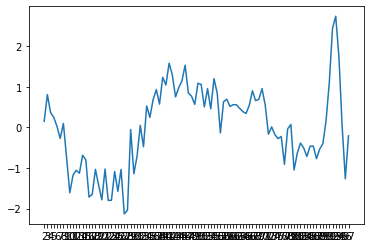

In [6]:
plt.plot(df.iloc[1,1:])

# Abnormal ECG plot : Myocardial Infarction

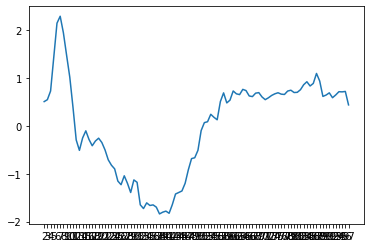

In [7]:
plt.plot(df.iloc[0,1:])

# ECG Data Stats

In [8]:
a = []
for i in range(0,df.shape[0]): a = a + list(df.iloc[i,1:])

print('max electric signal recorded :', max(a))
print('min electric signal recorded :', min(a))
print('mean electric signal recorded :', np.mean(a))
print('std electric signal recorded :', np.std(a))

max electric signal recorded : 4.1991449
min electric signal recorded : -2.6171746
mean electric signal recorded : 1.563919808470852e-10
std electric signal recorded : 0.9947780323086644


# Model

**Create Model**

In [9]:
tf.keras.backend.clear_session()

input1 = tf.keras.layers.Input(shape=(96,1))  

conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu',strides=1)(input1)
drop1 = tf.keras.layers.Dropout(0.5)(conv1)
pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
flat1 = tf.keras.layers.Flatten()(pool1)

conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu',strides=1)(input1)
drop2 = tf.keras.layers.Dropout(0.5)(conv2)
pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
flat2 = tf.keras.layers.Flatten()(pool2)

# conv3 = tf.keras.layers.Conv1D(filters=7, kernel_size=12, activation='relu', strides=1)(input1)
# drop3 = tf.keras.layers.Dropout(0.5)(conv3)
# pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
# flat3 = tf.keras.layers.Flatten()(pool3)

# conv4 = tf.keras.layers.Conv1D(filters=7, kernel_size=24, activation='relu',strides=1)(input1)
# drop4 = tf.keras.layers.Dropout(0.5)(conv4)
# pool4 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop4)
# flat4 = tf.keras.layers.Flatten()(pool4)

concate = tf.keras.layers.Concatenate()([flat1,flat2])

batch_norm = tf.keras.layers.BatchNormalization()(concate)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(batch_norm)

model = tf.keras.Model(inputs=input1, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 93, 32)       160         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 89, 32)       288         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 93, 32)       0           ['conv1d[0][0]']                 
                                                                                              

**Define loss optimizer and compile**

In [10]:
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer='adam', metrics=[tf.keras.metrics.Precision(thresholds=0.5),'accuracy'])

**Create Callback**

In [11]:
callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/saved_model/', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_freq='epoch'
)

**Train Model**

In [12]:
Model = model.fit(df1,np.array([1.0 if i==1 else 0.0 for i in df['1'] ]) , 
                  epochs=100, batch_size=16, validation_split= 0.25 ,
                  callbacks = [callback])

Epoch 1/100
5/5 [==============================] - 5s 874ms/step - loss: 0.0751 - precision: 0.8810 - accuracy: 0.7200 - val_loss: 0.0717 - val_precision: 0.6957 - val_accuracy: 0.7200
Epoch 2/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0528 - precision: 0.9762 - accuracy: 0.8267 - val_loss: 0.0861 - val_precision: 0.6667 - val_accuracy: 0.6800
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0445 - precision: 0.9184 - accuracy: 0.8400 - val_loss: 0.1066 - val_precision: 0.6400 - val_accuracy: 0.6400
Epoch 4/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0449 - precision: 0.9149 - accuracy: 0.8133 - val_loss: 0.1127 - val_precision: 0.6400 - val_accuracy: 0.6400
Epoch 5/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0349 - precision: 0.9400 - accuracy: 0.8800 - val_loss: 0.1066 - val_precision: 0.6400 - val_accuracy: 0.6400
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0248 

# Load model 

In [13]:
loded_model = tf.keras.models.load_model('/content/saved_model/')

**Classification report on train set**

In [14]:
print(classification_report( [1.0 if i==1 else 0.0 for i in df['1'] ]  ,[ float(i[0]>0.5) for i in  loded_model.predict(df1) ]))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.89        31
         1.0       1.00      0.88      0.94        69

    accuracy                           0.92       100
   macro avg       0.90      0.94      0.91       100
weighted avg       0.94      0.92      0.92       100



# Evaluation : Result on Test data

In [15]:
test = pd.read_csv('./test.csv')
truth_ = test['1']
test = test.iloc[:,1:]

**Classification report on test set**

In [16]:
print(classification_report( [1.0 if i==1 else 0.0 for i in truth_ ]  ,[ float(i[0]>0.5) for i in  model.predict(test) ] ))

              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84        36
         1.0       0.95      0.84      0.89        64

    accuracy                           0.87       100
   macro avg       0.86      0.88      0.86       100
weighted avg       0.88      0.87      0.87       100



**Parameters vs Epoch**

In [17]:
model_result = {'model_history' : Model.history}
history = pd.DataFrame(model_result['model_history'])
history['epoch'] = [i for i in range(1,history.shape[0]+1)]
fig_history =px.line(history, x=history.epoch, y=['loss', 'precision','accuracy','val_loss','val_precision','val_accuracy'])
fig_history.show()

# Dump

In [18]:
# report = classification_report([1.0 if i==1 else 0.0 for i in truth_ ], [ float(i[0]>0.5) for i in  model.predict(test) ], output_dict=True)
# report = pd.DataFrame(report).transpose()
# report['index'] = report.index
# dump(report,'/report_2.joblib')
# report

In [19]:
# from joblib import load,dump
# dump(report,'/report_2.joblib')

In [20]:
# load('report_.joblib')

In [21]:
# report

In [22]:
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Table(
#     header=dict(values=list(report.columns),
#                 fill_color='paleturquoise',
#                 align='left'),
#     cells=dict(values=report.transpose().values.tolist(),
#                fill_color='lavender',
#                align='left'))
# ])

# fig.show()

In [23]:
# ! pip install joblib
# import joblib
# joblib.__version__

In [24]:
# from joblib import load , dump

# model_result = {
#     'model_history' : Model.history,
#     'classification_report_test_set' : classification_report( [1.0 if i==1 else 0.0 for i in truth_ ]  ,[ float(i[0]>0.5) for i in  model.predict(test) ] )
# }
# dump(model_result,'model_result.joblib')

In [25]:
# model_result['classification_report_test_set']

In [26]:
# dump(model_result,'model_result.joblib')

In [27]:
# from joblib import load , dump

# result = load('model_result.joblib')

In [28]:
# result.keys()

In [29]:
# result['classification_report_test_set']

In [30]:
# a = result['classification_report_test_set'].split('\n')
# len(a)

In [31]:
# for i in a: print(i)

In [32]:
# result['model_history'].keys()

In [33]:
# fig = px.line(df, x='Date', y='AAPL.High')

# # Only thing I figured is - I could do this 
# fig.add_scatter(x=df['Date'], y=df['AAPL.Low']) # Not what is desired - need a line 


In [34]:
# result['model_history']

In [35]:
# ! pip install dash==2.0.0
# ! pip install plotly

In [36]:
# ! pip install plotly

In [37]:
# import plotly
# plotly.__version__

In [38]:
# import plotly
# plotly.__version__

In [39]:
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# import plotly.express as px
# import pandas as pd

# app = dash.Dash(__name__)

# # assume you have a "long-form" data frame
# # see https://plotly.com/python/px-arguments/ for more options
# df = pd.DataFrame({
#     "Fruit": ["Apples", "Oranges", "Bananas", "Apples", "Oranges", "Bananas"],
#     "Amount": [4, 1, 2, 2, 4, 5],
#     "City": ["SF", "SF", "SF", "Montreal", "Montreal", "Montreal"]
# })

# fig = px.bar(df, x="Fruit", y="Amount", color="City", barmode="group")

# app.layout = html.Div(children=[
#     html.H1(children='Hello Dash'),

#     html.Div(children='''
#         Dash: A web application framework for your data.
#     '''),

#     dcc.Graph(
#         id='example-graph',
#         figure=fig
#     )
# ])

# if __name__ == '__main__':
#     app.run_server(debug=True)

In [40]:
# fig = px.line(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16],)
# fig.add_scatter(x=[0, 1, 2, 3, 4], y=[10, 11, 41, 91, 161]) 
# fig.show()

In [41]:
# model_result = {'model_history' : Model.history}
# history = pd.DataFrame(model_result['model_history'])
# history['epoch'] = [i for i in range(1,history.shape[0]+1)]
# fig_history =px.line(history, x=history.epoch, y=['loss', 'precision','accuracy','val_loss','val_precision','val_accuracy'])
# fig_history.show()

In [42]:
# fig_history =px.line(history, x=history.epoch, y=['loss', 'precision','accuracy','val_loss','val_precision','val_accuracy'])
# fig_history.show()